# LRP using Abstract Semiring elements for the VGG-16 Network

## 0. Loading

In [64]:
import cv2
import torch
import torchvision
import numpy as np
import utils

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [65]:
img = np.array(cv2.imread('images/castle.jpg'))[...,::-1]/255.0

# values from https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html
mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)

X = (torch.FloatTensor(img[np.newaxis].transpose([0,3,1,2])*1) - mean) / std

In [66]:
model = torchvision.models.vgg16(pretrained=True); model.eval()
layers = list(model._modules['features']) + utils.toconv(list(model._modules['classifier']))
L = len(layers)

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 1. Class prediction

In [67]:
A = [X]+[None]*L
for l in range(L): A[l+1] = layers[l].forward(A[l])

In [68]:
scores = np.array(A[-1].data.view(-1))
ind = np.argsort(-scores)
for i in ind[:10]:
    print('%20s (%3d): %6.3f'%(utils.imgclasses[i][:20],i,scores[i]))

              castle (483): 11.029
church, church build (497):  9.522
           monastery (663):  9.401
 bell cote, bell cot (442):  9.047
cinema, movie theate (498):  8.016
        analog clock (409):  7.108
         street sign (919):  7.102
traffic light, traff (920):  7.058
thatch, thatched roo (853):  6.978
                 alp (970):  6.812


## 2. LRP

In [69]:
T = torch.FloatTensor((1.0*(np.arange(1000)==483).reshape([1,1000,1,1])))

In [70]:
R = [None]*L + [(A[-1]*T).data]

In [71]:
for l in range(1,L)[::-1]:
    
    A[l] = (A[l].data).requires_grad_(True)

    if isinstance(layers[l],torch.nn.MaxPool2d):
        layers[l] = torch.nn.AvgPool2d(2)

    if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):

        if l <= 16:       
            rho = lambda p: p + 0.25*p.clamp(min=0)
            incr = lambda z: z+1e-9
        if 17 <= l <= 30: 
            rho = lambda p: p 
            incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        if l >= 31:
            rho = lambda p: p
            incr = lambda z: z+1e-9

        z = incr(utils.newlayer(layers[l],rho).forward(A[l]))
        s = (R[l+1]/z).data
        (z*s).sum().backward()
        c = A[l].grad
        R[l] = (A[l]*c).data
        
    else:
        
        R[l] = R[l+1]

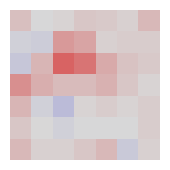

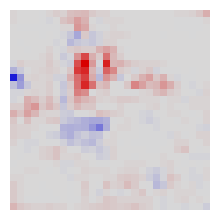

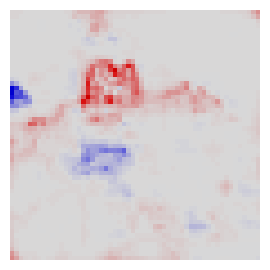

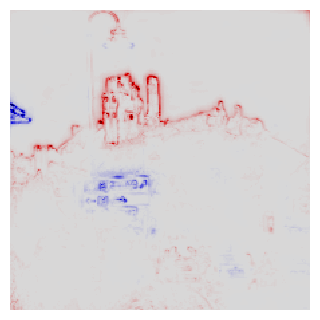

In [72]:
for i,l in enumerate([31,21,11,1]):
    utils.heatmap(np.array(R[l][0]).sum(axis=0),0.5*i+1.5,0.5*i+1.5)

In [73]:
A[0] = (A[0].data).requires_grad_(True)

lb = (A[0].data*0+(0-mean)/std).requires_grad_(True)
hb = (A[0].data*0+(1-mean)/std).requires_grad_(True)

z = layers[0].forward(A[0]) + 1e-9
z -= utils.newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)
z -= utils.newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)
s = (R[1]/z).data
(z*s).sum().backward(); c,cp,cm = A[0].grad,lb.grad,hb.grad
R[0] = (A[0]*c+lb*cp+hb*cm).data

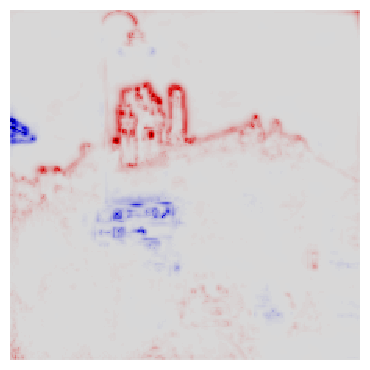

In [74]:
utils.heatmap(np.array(R[0][0]).sum(axis=0),3.5,3.5)

### 3. LRP Simplification
Instead of a rafined setup, we consider $\epsilon=0$, $\rho(x)=x$, we do not normalize the relevance, and we apply the LRP-0 rule for every layer, including the last one (no $z^\mathcal{B}$).

In [75]:
R_simp = [None]*L + [(A[-1]*T).data]

In [81]:
for l in range(0,L)[::-1]:
    A[l] = (A[l].data).requires_grad_(True)

    if isinstance(layers[l],torch.nn.MaxPool2d):
        layers[l] = torch.nn.AvgPool2d(2)

    if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):

        if l == 0:
            rho = lambda p: p
            incr = lambda z: z+1e-9
        elif l <= 16:       
            rho = lambda p: p + 0.25*p.clamp(min=0)
            incr = lambda z: z+1e-9
        elif 17 <= l <= 30: 
            rho = lambda p: p 
            incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        elif l >= 31:
            rho = lambda p: p
            incr = lambda z: z+1e-9

        z = incr(utils.newlayer(layers[l],rho).forward(A[l]))
        s = (R_simp[l+1]/z).data
        (z*s).sum().backward()
        c = A[l].grad
        R_simp[l] = (A[l]*c).data
        
    else:
        R_simp[l] = R_simp[l+1]

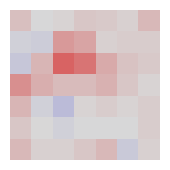

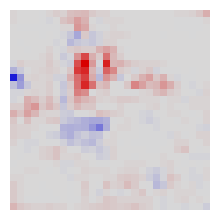

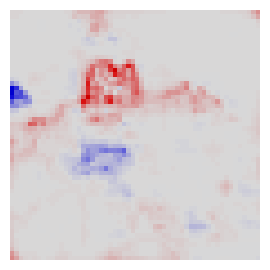

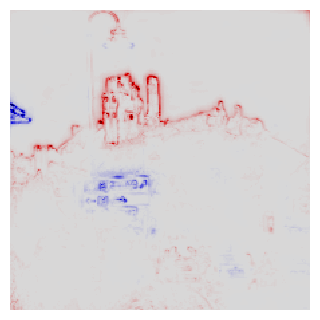

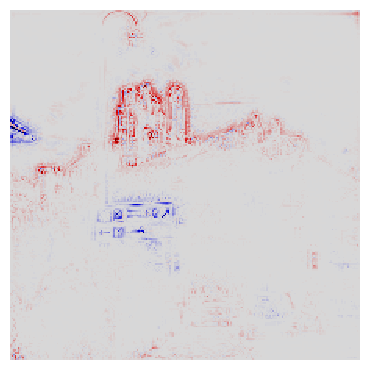

In [82]:
for i,l in enumerate([31,21,11,1, 0]):
    utils.heatmap(np.array(R_simp[l][0]).sum(axis=0),0.5*i+1.5,0.5*i+1.5)

### Comparaison of the methods

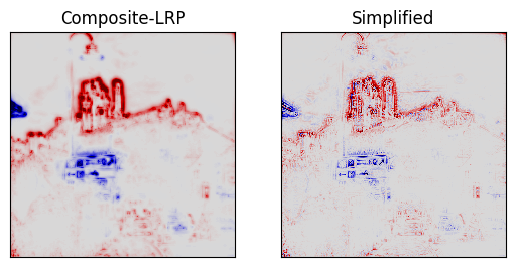

In [83]:
my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
my_cmap[:,0:3] *= 0.85
my_cmap = ListedColormap(my_cmap)

fig, axs = plt.subplots(1, 2)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])

b = 10*(np.abs(np.array(R[0][0]))**3.0).mean()**(1.0/3)
axs[0].imshow(np.array(R[0][0]).sum(axis=0), cmap=my_cmap,vmin=-b,vmax=b,interpolation='nearest')
axs[0].set_title("Composite-LRP")


b = 10*(np.abs(np.array(R_simp[0][0]))**3.0).mean()**(1.0/3)
axs[1].imshow(np.array(R_simp[0][0]).sum(axis=0),cmap=my_cmap,vmin=-b,vmax=b,interpolation='nearest')
axs[1].set_title("Simplified")

plt.show()